In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Ensure chessimg2pos is importable whether installed via pip or run from a cloned repo
try:
    import chessimg2pos  # noqa: F401
except ImportError:
    import sys, os

    # Notebook is inside examples/ — src is one level up
    sys.path.insert(0, os.path.abspath("../src"))

# Training a Chess Position Recognition Model

This notebook walks through training a chess piece classifier from a dataset of chessboard images.

### Dataset format
Each chessboard image must be named using its FEN notation with `/` replaced by `-`, e.g.:

```
rnbqkbnr-pppppppp-8-8-8-8-PPPPPPPP-RNBQKBNR.png
```

Place all board images under a single directory (subdirectories are supported — the trainer scans recursively).

In [3]:
from chessimg2pos import ChessRecognitionTrainer, ChessPositionPredictor
from chessimg2pos.constants import (
    DEFAULT_CLASSIFIER,
    DEFAULT_USE_GRAYSCALE,
    DEFAULT_FEN_CHARS,
)

## Configuration

In [4]:
# Each FEN char represents the contents of a chessboard tile.
# Must match the string used when loading a model for prediction.
FEN_CHARS = DEFAULT_FEN_CHARS  # "1RNBQKPrnbqkp"
USE_GRAYSCALE = DEFAULT_USE_GRAYSCALE  # True

# Paths — adjust to your local setup
CHESSBOARDS_DIR = "../../training_images/chessboards"  # directory of board images
# Optional: separate directory for generated tile images.
# If None, tiles are saved inside CHESSBOARDS_DIR/tiles (legacy behaviour).
TILES_DIR = None  # e.g. "../../training_images/tiles"

CLASSIFIER = DEFAULT_CLASSIFIER  # "enhanced" | "standard" | "ultra"
MODEL_SAVE_PATH = "../../models/model_enhanced.pt"  # where the trained model is saved

## (Optional) Clean up corrupted tile folders

Run this cell to detect tile folders that don't contain exactly 64 images, and remove any "copy" artefacts left by macOS or Windows file managers.

In [5]:
import os
import shutil

tiles_dir_to_check = TILES_DIR or os.path.join(CHESSBOARDS_DIR, "tiles")


def find_invalid_tile_folders(parent_dir):
    """Checks each subfolder in parent_dir for exactly 64 tile images."""
    invalid = []
    if not os.path.exists(parent_dir):
        print(f"Directory does not exist yet: {parent_dir}")
        return invalid
    for subfolder in os.listdir(parent_dir):
        subfolder_path = os.path.join(parent_dir, subfolder)
        if os.path.isdir(subfolder_path):
            count = len(os.listdir(subfolder_path))
            if count != 64:
                print(f"  WARNING: '{subfolder}' has {count} items (expected 64)")
                invalid.append(subfolder_path)
    return invalid


def delete_copy_files_and_folders(root_dir):
    """Delete files and folders whose names contain 'copy'."""
    for dirpath, dirnames, filenames in os.walk(root_dir, topdown=False):
        for filename in filenames:
            if "copy" in filename.lower():
                filepath = os.path.join(dirpath, filename)
                print(f"Deleting file: {filepath}")
                os.remove(filepath)
        for dirname in dirnames:
            if "copy" in dirname.lower():
                folderpath = os.path.join(dirpath, dirname)
                print(f"Deleting folder: {folderpath}")
                shutil.rmtree(folderpath)


bad_folders = find_invalid_tile_folders(tiles_dir_to_check)
print(f"Folders with incorrect tile count: {bad_folders}")

delete_copy_files_and_folders(CHESSBOARDS_DIR)

Directory does not exist yet: ../../training_images/chessboards/tiles
Folders with incorrect tile count: []


## Train — Standard model

In [6]:
trainer = ChessRecognitionTrainer(
    images_dir=CHESSBOARDS_DIR,
    tiles_dir=TILES_DIR,  # None falls back to images_dir/tiles
    model_path="../../models/model_standard.pt",
    fen_chars=FEN_CHARS,
    use_grayscale=USE_GRAYSCALE,
    epochs=10,
    generate_tiles=True,  # Set False if tiles were already generated
    overwrite=False,
)
model, device, accuracy = trainer.train(classifier="standard")
print(f"Standard model accuracy: {accuracy:.4f}")

Processed 788 chessboard images (788 generated, 0 skipped, 0 failed)


2026-02-27 11:21:56,851 - INFO - Model architecture:
ChessPieceClassifier(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=13, bias=True)
  )
)
2026-02-27 11:21:56,851 - INFO - Total parameters: 318,797
2026-02-27 11:21:56,852 - INFO - Using classifier: standard
2026-02-27 11:22:12,714 - INFO - Epoch 1/10, Train Loss: 0.1203, Train Acc: 0.9646, Val Loss: 0.0048, Val Acc: 0.9991
20

Standard model accuracy: 0.9997


## Train — Enhanced model

In [7]:
trainer = ChessRecognitionTrainer(
    images_dir=CHESSBOARDS_DIR,
    tiles_dir=TILES_DIR,
    model_path="../../models/model_enhanced.pt",
    fen_chars=FEN_CHARS,
    use_grayscale=USE_GRAYSCALE,
    epochs=10,
    generate_tiles=False,  # Tiles already generated above
)
model, device, accuracy = trainer.train(classifier="enhanced")
print(f"Enhanced model accuracy: {accuracy:.4f}")

2026-02-27 11:24:26,024 - INFO - Model architecture:
EnhancedChessPieceClassifier(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, tr

Enhanced model accuracy: 0.9998


## Train — Ultra model

In [8]:
trainer = ChessRecognitionTrainer(
    images_dir=CHESSBOARDS_DIR,
    tiles_dir=TILES_DIR,
    model_path="../../models/model_ultra.pt",
    fen_chars=FEN_CHARS,
    use_grayscale=USE_GRAYSCALE,
    epochs=10,
    generate_tiles=False,
)
model, device, accuracy = trainer.train(classifier="ultra")
print(f"Ultra model accuracy: {accuracy:.4f}")

2026-02-27 11:27:23,338 - INFO - Model architecture:
UltraEnhancedChessPieceClassifier(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), paddi

Ultra model accuracy: 0.9999


## Evaluate on a test image

Predicted FEN : 11111111/11111111/11111111/1111p1K1/11k1P111/11111111/11111111/11111111
Confidence    : 0.1639


2026-02-27 11:30:28,874 - INFO - Lichess editor: https://lichess.org/editor/11111111/11111111/11111111/1111p1K1/11k1P111/11111111/11111111/11111111


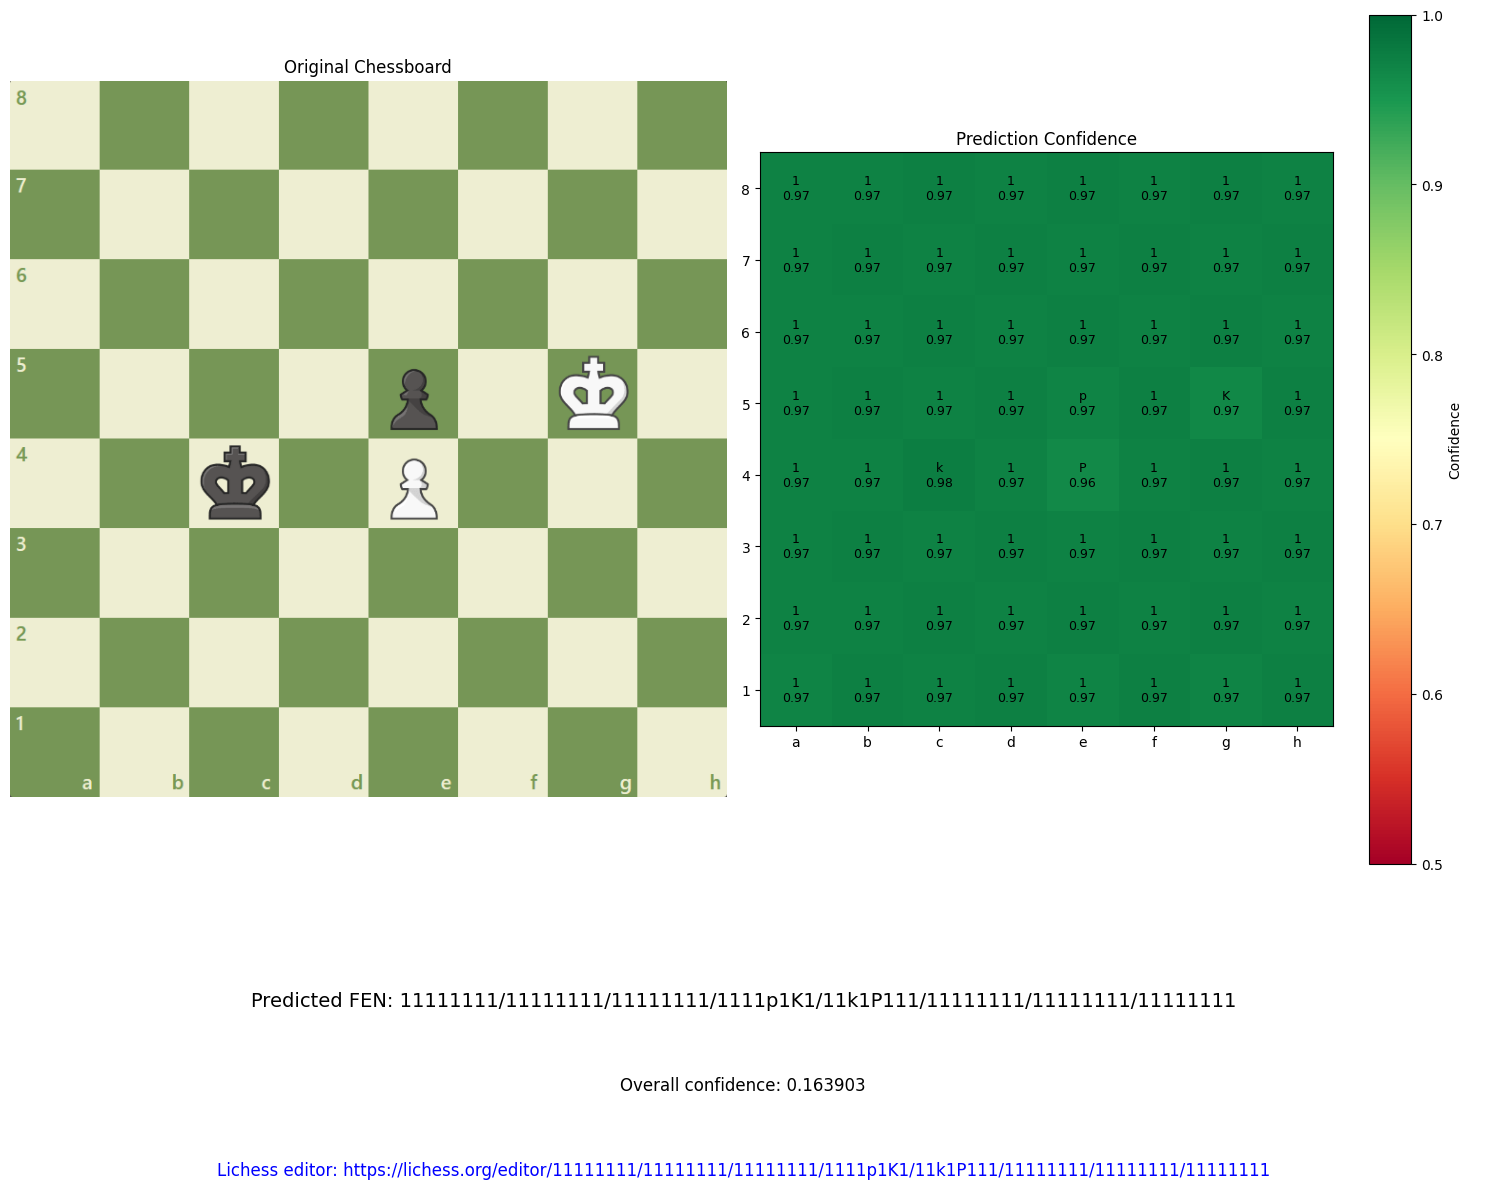

In [9]:
import matplotlib.pyplot as plt
from PIL import Image

image_path = "../images/chess_image.png"  # replace with your test image

predictor = ChessPositionPredictor(
    model_path="../../models/model_enhanced.pt",
    classifier="enhanced",
    use_grayscale=USE_GRAYSCALE,
    fen_chars=FEN_CHARS,
)

results = predictor.predict_chessboard(image_path, return_tiles=True)
print(f"Predicted FEN : {results['fen']}")
print(f"Confidence    : {results['confidence']:.4f}")

fig = predictor.visualize_prediction(results)
plt.show()